# riteshhere Speech Diarization

n.b. This Jupyter notebook was copied from [riteshhere/Speaker_diarization](https://github.com/riteshhere/Speaker_diarization) and then modified.

In [12]:
# Imports
from dotenv import find_dotenv
from dotenv import dotenv_values
config = dotenv_values(find_dotenv())
# NOTE: empty `.env` file was added beneath `src` directory. Ignored by gitignore rules.
import os
import sys
sys.path.append(os.path.dirname(find_dotenv()))
from notebooks.notebook_utils import DevData
# ----------------------------------------
# load huggingface token from .env file
HUGGINGFACE_TOKEN = config["HUGGINGFACE_TOKEN"]

In [21]:
# define paths
external_dir = DevData().external_dir
mp3_file = os.path.join(external_dir, "Laughter_Lift.mp3")
# outpath = os.path.join(external_dir, "audio_20231020.rttm")
transcript_path = os.path.join(external_dir, "transcript.txt")
print(f"mp3_file exists: {os.path.exists(mp3_file)}")

mp3_file exists: True


In [3]:
num_speakers = 2 #@param {type:"integer"}
language = 'English' #@param ['any', 'English']
model_size = 'medium' #@param ['tiny', 'base', 'small', 'medium', 'large']

model_name = model_size
if language == 'English' and model_size != 'large':
  model_name += '.en'

In [8]:
# !pip install -q git+https://github.com/openai/whisper.git > /dev/null
# !pip install -q git+https://github.com/pyannote/pyannote-audio > /dev/null

import whisper
import datetime

import subprocess

import torch
import pyannote.audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# embedding_model = PretrainedSpeakerEmbedding(
#     "speechbrain/spkrec-ecapa-voxceleb",
#     device=torch.device("cuda"))

embedding_model = PretrainedSpeakerEmbedding(
    "speechbrain/spkrec-ecapa-voxceleb")

from pyannote.audio import Audio
from pyannote.core import Segment

import wave
import contextlib

from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [9]:
model = whisper.load_model(model_size)

In [14]:
result = model.transcribe(mp3_file)
segments = result["segments"]

In [7]:
# hmmm I'm using mp3 not wav file so this doesn't work. TODO: Can probably use mutagen instead to get duration. 

# with contextlib.closing(wave.open(path,'r')) as f:
#   frames = f.getnframes()
#   rate = f.getframerate()
#   duration = frames / float(rate)

In [18]:
audio = Audio()

def segment_embedding(segment):
  start = segment["start"]
  # Whisper overshoots the end timestamp in the last segment
  # end = min(duration, segment["end"])
  end = segment["end"]  # just use whisper's end for now
  clip = Segment(start, end)
  waveform, sample_rate = audio.crop(mp3_file, clip)
  return embedding_model(waveform[None])

In [19]:
embeddings = np.zeros(shape=(len(segments), 192))
for i, segment in enumerate(segments):
  embeddings[i] = segment_embedding(segment)

embeddings = np.nan_to_num(embeddings)

In [26]:
clustering = AgglomerativeClustering(num_speakers).fit(embeddings)
labels = clustering.labels_
for i in range(len(segments)):
  segments[i]["speaker"] = 'SPEAKER ' + str(labels[i] + 1)

In [28]:
def time(secs):
  return datetime.timedelta(seconds=round(secs))

f = open(transcript_path, "w")
x = ""
for (i, segment) in enumerate(segments):
  if i == 0 or segments[i - 1]["speaker"] != segment["speaker"]:
    f.write("\n" + segment["speaker"] + ' ' + str(time(segment["start"])) + '\n')
  f.write(segment["text"][1:] + ' ')
  x += "\n" + segment["speaker"] + ' ' + str(time(segment["start"])) + '\n'
  x += segment["text"][1:] + ' '
f.close()

In [29]:
print(open(transcript_path).read())


SPEAKER 2 0:00:00
More with Emily Watson in take two, ads in a minute. But first, it's time once again, very, very good news everybody, we step into our laughter lift. 
SPEAKER 1 0:00:08
Huzzah. Shazam. Here we go. Hey Mark, seeing as you loved the noble gases joke so much last week, I was going to tell you another one, but all the good ones are gone. 
SPEAKER 2 0:00:21
I got that, I got that, because argon's a gas. It is, it's a noble gas. 
SPEAKER 1 0:00:24
I got it, okay. Anyway, here's another science you want for you, are you ready? I was out at a pub with rooms in Chobhub's North London on Saturday for a wedding reception. A neutron walked in. 
SPEAKER 2 0:00:35
How much for a pint, he said. 
SPEAKER 1 0:00:36
For you, no charge, said the barman. And I get that as well, because a neutron has no charge. Subatomic particle with no charge. 
SPEAKER 2 0:00:43
And then a photon walked in. I'd like a room for the night, please, he said. Certainly, do you have any luggage we can take u

In [30]:
print(result)

{'text': " More with Emily Watson in take two, ads in a minute. But first, it's time once again, very, very good news everybody, we step into our laughter lift. Huzzah. Shazam. Here we go. Hey Mark, seeing as you loved the noble gases joke so much last week, I was going to tell you another one, but all the good ones are gone. I got that, I got that, because argon's a gas. It is, it's a noble gas. I got it, okay. Anyway, here's another science you want for you, are you ready? I was out at a pub with rooms in Chobhub's North London on Saturday for a wedding reception. A neutron walked in. How much for a pint, he said. For you, no charge, said the barman. And I get that as well, because a neutron has no charge. Subatomic particle with no charge. And then a photon walked in. I'd like a room for the night, please, he said. Certainly, do you have any luggage we can take up to the room? Asked the receptionist. No, said the photon. I'm traveling light. Because a photon is a... It is a light pa

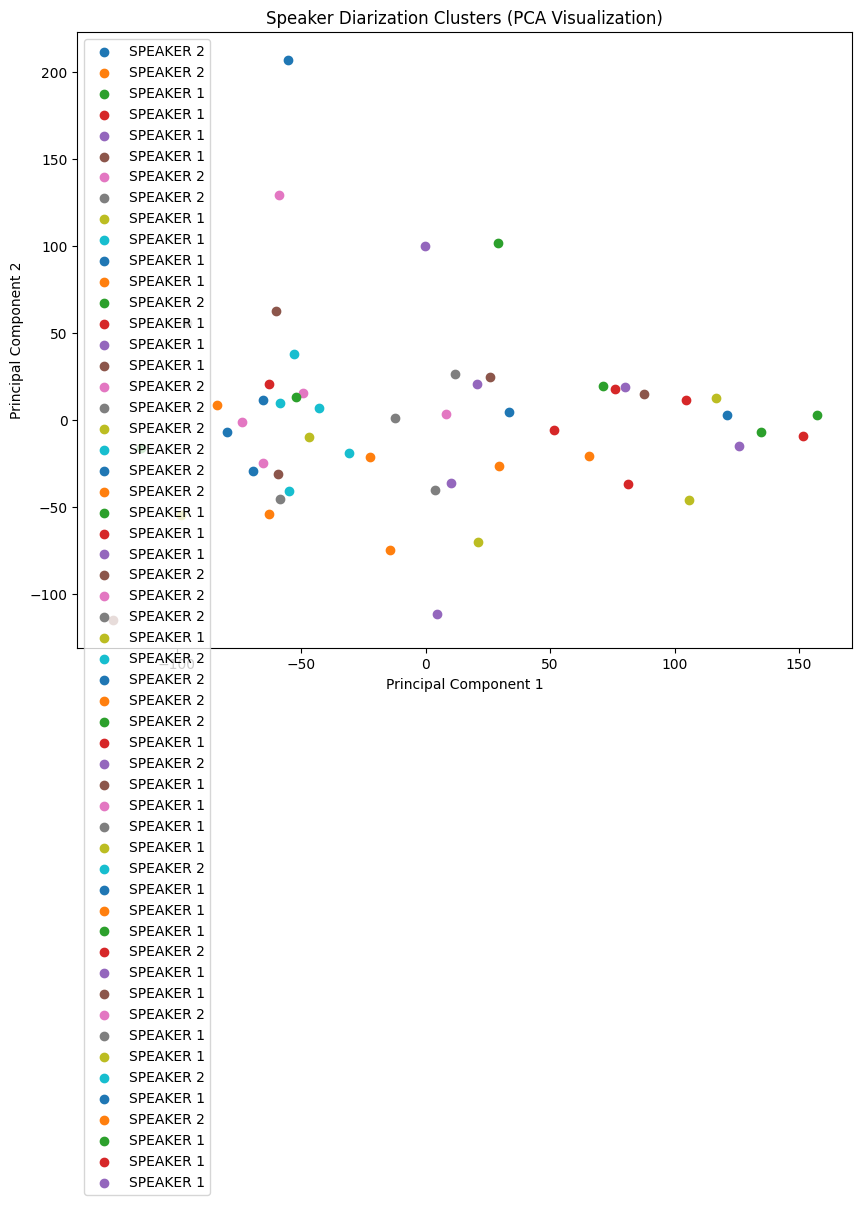

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Your existing code for clustering and labeling segments...

# Perform PCA to reduce the dimensionality of embeddings to 2D
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i, segment in enumerate(segments):
    speaker_id = labels[i] + 1
    x, y = embeddings_2d[i]
    plt.scatter(x, y, label=f'SPEAKER {speaker_id}')

plt.title("Speaker Diarization Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


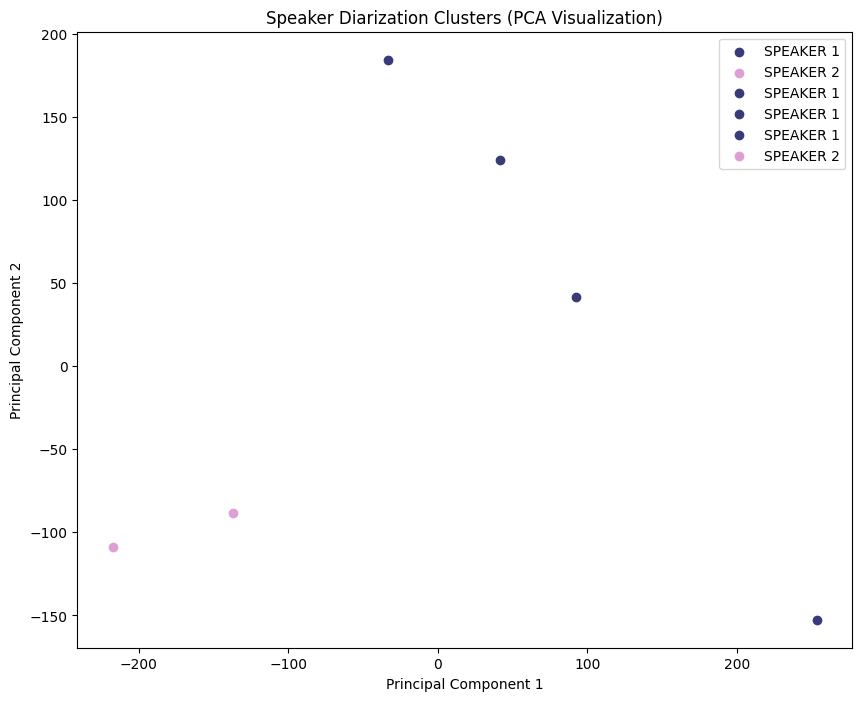

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Your existing code for clustering and labeling segments...

# Perform PCA to reduce the dimensionality of embeddings to 2D
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Get the number of unique speakers from the labels
num_unique_speakers = len(np.unique(labels))

# Create a colormap for speakers, ensuring each speaker gets a unique color
colors = cm.tab20b(np.linspace(0, 1, num_unique_speakers))

# Plot the clusters
plt.figure(figsize=(10, 8))
for i, segment in enumerate(segments):
    speaker_id = labels[i] + 1
    x, y = embeddings_2d[i]
    color = colors[labels[i] % num_unique_speakers]  # Get the corresponding color for the speaker
    plt.scatter(x, y, label=f'SPEAKER {speaker_id}', color=color)

plt.title("Speaker Diarization Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


In [33]:
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Your existing code for clustering and labeling segments...

# Perform PCA to reduce the dimensionality of embeddings to 3D
pca = PCA(n_components=3, random_state=42)
embeddings_3d = pca.fit_transform(embeddings)

# Get the number of unique speakers from the labels
num_unique_speakers = len(np.unique(labels))

# Create a colormap for speakers, ensuring each speaker gets a unique color
colors = cm.tab20b(np.linspace(0, 1, num_unique_speakers))

# Prepare the data for the 3D scatter plot
data = []
for i, segment in enumerate(segments):
    speaker_id = labels[i] + 1
    x, y, z = embeddings_3d[i]
    color = colors[labels[i] % num_unique_speakers]  # Get the corresponding color for the speaker
    trace = go.Scatter3d(x=[x], y=[y], z=[z], mode='markers',
                         marker=dict(size=5, color=color),
                         name=f'SPEAKER {speaker_id}')
    data.append(trace)

# Layout for the 3D scatter plot
layout = go.Layout(
    title="Speaker Diarization Clusters (3D Visualization)",
    scene=dict(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        zaxis_title="Principal Component 3"
    )
)

# Create the figure and plot the 3D scatter plot
fig = go.Figure(data=data, layout=layout)
fig.show()
